# Arrays, cellular automata, and percolation 

Think of these homeworks like solving a crossword puzzle: the answers are easy to find online, but the fun part is seeing how far you can get without looking up the solutions.

If you are new to Python and finding this problem set to be a severe time burden, don't worry too much about it---just do what you can. Please feel free to use any resources---online code, classmates, textbooks, etc---to help with this problem set if needed. Please cite your sources and acknowledge classmate or online repos (as you would in a publication). 

Imports: Make sure these are installed in your conda env, and that the conda env is active in your notebook
+ numpy
+ matplotlib
+ scipy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The Game of Life and arrays

Cellular automata represent an intriguing example of a physical system where surprising complexity emerges from relatively simple rules.

1. Implement the Game of Life in Python
2. If the number of pixels in the initial conditions is equal to $N$ (for example, we have an $\sqrt{N}\times\sqrt{N}$ input image), then how does the runtime and memory of a single update step scale with $N$?
3. 


In [ ]:
class CellularAutomaton:

    def __init__(self, n_states, n_neighbors, initial_state):
        self.n_states = n_states
        self.n_neighbors = n_neighbors
        self.initial_state = initial_state
        self.state = initial_state

    def step(self):
        """
        Output the next state of the entire board
        """
        self.state = self.next_state()
        return self.state

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.step()
        return self.state


class GameOfLife(CellularAutomaton):

    def __init__(self, n_states, **kwargs):
        super().__init__(n_states=2, **kwargs)

    def next_state(self):
        """
        Compute the next state of the board
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)
        for i in range(self.state.shape[0]):
            for j in range(self.state.shape[1]):
                # Compute the number of neighbors
                n_neighbors = 0
                for ii in range(-1, 2):
                    for jj in range(-1, 2):
                        if ii == 0 and jj == 0:
                            continue
                        try:
                            n_neighbors += self.state[i+ii, j+jj]
                        except IndexError:
                            continue
                # Update the next state
                if self.state[i, j] == 1:
                    if n_neighbors in [2, 3]:
                        next_state[i, j] = 1
                else:
                    if n_neighbors == 3:
                        next_state[i, j] = 1
        return next_state

Cellular automata have a rich history in the physics literature, although their popularity has declined somewhat due to a lack of analytical tools for working with their governing equations. 

One common criticism of Game-of-Life like CAs comes from their requirement of a *synchronous* update rule: all of the cells update to a new state at the same time: the value of a cell x_{ij}(t+1) depends on the "frozen" values x_{ij}(t) and its neighbors at t. In a real-world system, updates are asynchronous: different cells will update at different times. One way of thinking about asynchronous updates is that we only update a single cell in a given timestep, and we gradually raster-scan across the entire image to update all cells sequentially. Asynchronous update rules usually have qualitatively distinct dynamics than synchronous CA.

With what you know about scaling of time and space complexity, can you figure out why asynchronous updates might be more biologically plausaible?




Some thoughts: while deep learning is in the news, the most popular machine learning algorithms are practical applications are likely random forests, which involve training an ensemble of small machine learning models (decision trees), and averaging their results to generate a consensus prediction or classification. A powerful variant of RF are so-called gradient-boosted decision trees, in which individual decision trees are trained sequentially based on errors from previous trees. Training random forests vs boosted trees are a nice example of a synchronous vs asynchronous algorithm.

# The Abelian sandpile

### Background

We are going to implement the celebrated [Bak-Tang-Wiesenfeld model](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.381), also known as the "Abelian sandpile." This cellular automaton describes a lattice in which sand grains are continuously dropped onto random locations at a fixed rate, resulting in the formation of random sandpiles. When the sandpiles grow too high, they topple, resulting in avalanches that distribute grains to all of their neighbors.

If we denote the number of grains at a site $(x, y)$ as $z(x, y)$, a single "topple" event of the BTW model has the following update rule, which triggers only when $z >= 4$.

1. $z(x, y) \rightarrow z(x, y) - 4$
2. $z(x \pm 1, y \pm 1) \rightarrow z(x \pm 1, y \pm 1) + 1$

After a single topple event, the entire lattice is checked to see if any other sites now have $z \geq 4$, in which case those sites are toppled, too. If a site located at the boundary of the domain topples, then any grains that would go out of bounds are assumed to be permanently lost from the system. After all sites reach a state where $z \leq 4$, the avalanche has concluded. We then add a sand grain to a random new site, and calculate any new resulting avalanches.

This idealized system has several interesting properties: the continuous addition of grains represents a slow-timescale driving process, which effectively injects energy into the system. The avalances represent fast-timescale response dynamics, and the grains that fall off the edges represent dissipation---they prevent avalanches from continuing forever undriven. Despite its seeming simplicity, the BTK model represents perhaps the earliest widely-studied toy model of "self-organized criticality," a well-known hypothesis in nonequilibrium statistical physics that driven, dissipative systems tend to tune themselves into maximally-critical states (there are always sandpiles on the verge of toppling). The sandpile has been used as a thought experiment describing an incredible array of diverse systems, including: starts and stops in dragging friction, [earthquakes](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB094iB11p15635), timings between geyser eruptions, [timings of pulsar glitches](https://arxiv.org/abs/1403.6528), [fluctuations in an ultracold atomic gas](https://www.nature.com/articles/s41586-019-1908-6), [neuronal activity patterns in the brain](https://www.frontiersin.org/articles/10.3389/fnsys.2014.00166/full), [flux pinning](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.67.919), and many other areas.

A simple signature of self-organized-criticality observed in the sandpile model, which also represents an easy readout for experimental data, is the appearance of $1/f$ noise, where $f$ denotes frequency. This distribution implies that avalanche durations have a skewed distribution, where larger events happen less frequently. For an experimental system, this results in "crackling" or brown noise. In the BTW model, the authors note that a $1/f$ distribution of rare events in the frequency corresponds to a $1/T$ distribution of waiting times between rare events. 

Here we will implement the BTW model, and then test for the appearance of $1/f$ noise.

### TODO:

1. Implement the Abelian Sandpile model and compute its dynamics
2. Show that your model exhibits a $1/T^\alpha$ waiting time between avalanches
3. If a single image of the sandpile has size $N$ (the total number of lattice sites), what do you expect to be the worst-case scaling of the runtime of your algorithm? What about the expected scaling of memory usage?
4. (Hard, optional) Try [vectorizing](https://realpython.com/numpy-array-programming/) your sandpile implementation, in order to reduce the number of "for" loops used in your implementation. How does vectorization decrease the runtime?

**If any student wants to try to implement the Kramer & Marder paper linked below instead of doing the BTK model, feel free to attempt it. I don't have a solution for it**

### Fun facts

Like many "universal" theories in physics, many scientists in other domains (especially biology) are now appropriately skeptical of the generality of these claims. But the BTW model nonetheless represents an extremely influential model in statistical physics, in which a very simple thought experiment lead to extremely influential results. Among cellular automata, the BTW model is not only unique for its asynchronous nature, but also because it has a "derivative" ruleset in contrast to the "integral"/totalistic ruleset we see in better-known systems like the Game of Life: instead of updating a cell based on the sum of all its neighbors, we update all neighbors based on the state of a cell.

Another member of our department, Michael Marder, has a [paper from 1992 in which he and his student Steve Kramer propose a cellular automaton model of river formation.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.205) (Figure 2 is gorgeous!). The update rules and structure of implementing this simulation have many simularities to the BTK model, but, unlike the BTK model, I have never seen an implementation of this model outside of this paper, but would be really cool to sometime see high-res simulations and videos of this model.



Text(0.5, 1.0, 'Final state')

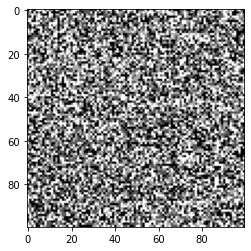

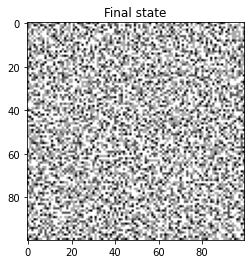

In [164]:
class AbelianSandpile:
    """
    An Abelian sandpile model simulation
    """

    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state) # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history =[self.grid.copy()] # Why did we need to copy the grid?
        self.all_durations = list() # useful to keep track of the duration of toppling events


    def step(self):
        """
        A single step of the simulation consists of two stages: a random sand grain is 
        dropped onto the lattice at a random location. Then, a set of avalanches occurs
        causing sandgrains to get redistributed to their neighboring locations.


        + I'd recommend using a while loop for the toppling events
        + We will use absorbing boundary conditions: excess sand grains fall off the edges
        of the grid.
        + In addition to updating self.grid, keep track of the topple durations in the 
        instance variable self.all_durations

        """

        ## YOUR CODE HERE ##

        # Drop a grain at a random location
        xi, yi = np.random.choice(self.n, 2)
        self.grid[xi, yi] += 1

        # Topple the sand grains
        duration = 0
        while np.any(self.grid >= 4):
            topple_inds = np.where(self.grid >= 4)
            sel_ind = np.random.choice(np.arange(len(topple_inds[0])))
            ii, jj = (topple_inds[0][sel_ind], topple_inds[1][sel_ind])
            self.grid[ii, jj] -= 4
            if ii > 0:
                self.grid[ii - 1, jj] += 1
            if ii < self.n - 1:
                self.grid[ii + 1, jj] += 1
            if jj > 0:
                self.grid[ii, jj - 1] += 1
            if jj < self.n - 1:
                self.grid[ii, jj + 1] += 1
            duration += 1
        if duration > 0:
            self.all_durations.append(duration)

    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    
    def simulate(self, n_step):
        """
        Simulate the sandpile model for n_step steps. If record_events is True, store
        snapshots of the grid every time a change is detected
        """
        for i in range(n_step):
            self.step()
            if self.check_difference(self.grid, self.history[-1]) > 0:
                self.history.append(self.grid.copy())
        return self.grid

model = AbelianSandpile(n=100, random_state=0)

plt.figure()
plt.imshow(model.grid, cmap='gray')


model.simulate(10000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")


Text(0, 0.5, 'Count')

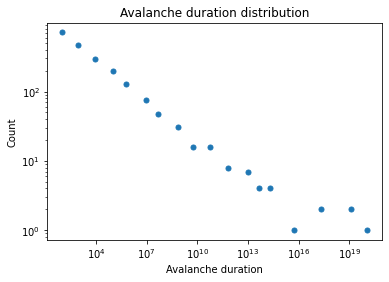

In [165]:
# Compute the pairwise difference between all observed snapshots. This command uses list
# comprehension, a zip generator, and argument unpacking in order to perform this task
# concisely.
all_events =  [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]

# remove transients before the self-organized critical state is reached
all_events = all_events[1000:]

# index each timestep by timepoint
all_events = list(enumerate(all_events))


# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]

all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes= [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]



# vals, bins = np.histogram(all_avalanche_sizes, bins=np.logspace(np.log10(4), np.log10(1000), 50))
# plt.figure()
# plt.semilogy(bins[:-1], vals, '.', markersize=10)
# plt.title('Avalanche size distribution')
# plt.xlabel('Avalanche size')
# plt.ylabel('Count')

# vals, bins = np.histogram(all_avalanche_durations)
# plt.figure()
# plt.loglog(bins[:-1], vals, '.',  markersize=10)
# # plt.loglog(bins[:-1], (vals[0] / bins[0]) * bins[:-1]**(-1), '-k') # plot 1/T scaling


log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(10**bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')

Text(0.5, 1.0, 'Avalanch activity in most recent timesteps')

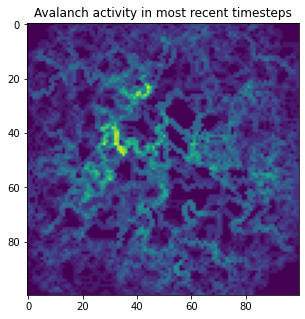

In [182]:
## Visualize activity of the avalanches

# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1

all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events

most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanch activity in most recent timesteps")

# Percolation

Cellular automata might seem like a bit of a niche topic, but we can use some of the ideas we've seen in the CA literature to approach a problem that is *definitely* applicable to many problems in physics. Percolation is a great example of a problem demonstrating a universality class.

The basic idea is pretty simple: given a D-dimensional lattice (for example, a 2D grid), we randomly mark sites as "blocked" or "open" with probability $p$. For a given value fo $p$, what is the probability that water poured into the top of the lattice will percolate to the bottom row through all of the open sites?

This basic problem maps onto all sorts of interesting problems in physics and graph theory. For directed percolation (in which we have a preferred flow direction in the lattice), there is [an elegant 2016 Nature Physics paper](https://www.nature.com/articles/nphys3548) showing similar scaling exponents in ecological collapse and pipe turbulence, because the two problems mathematically map onto the DP universality class. [Here's another recent paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007508) that uses percolation theory to understand electrical signalling between neighboring cells in a biofilm. 

If you are interested in the mathematical theory of percolation, [Kim Christensen's notes on the subject](https://web.mit.edu/ceder/publications/Percolation.pdf) are extremely clear and interesting.


Questions:

1. Implement a two dimensional directed percolation model in Python. I've included a code outline below.
    + The naive solution simulates water pouring into the top row, and then iterate over rows and sites
    + Can you think of a faster way of solving this problem? (Hint: we may not have seen recursion in class yet, but it may be helpful). If you want to try implementing your solution, you will need to add an additional private method `_flow_recursive(i, j)` that contains the recursive logic
2. Perform replicate simulations using the code I've provided below, create a plot showing how the probability of percolation changes as a function of N (the lattice size). Beyond seeing the predictable percolation to clogging transition, you'll notice that the variance in the outcome of your simulations behaves unexpectedly. What is going on here? (Hint: If you've studied the Ising model, you've seen something like this before)
3. Theoretically, does the transition point seen in our empirical results align with your intuition? Can you make a simple statistical argument for the percolation threshold? (Hint: think about counting occupied sites versus counting links between sites)
4. How does the memory usage and runtime of your percolation model implement scale with the lattice size? You can answer this empirically or theoretically.
5. In our simulations, we generated random lattices and then ran percolation simulations. There is [another way to calculate the percolation threshold using Monte-Carlo methods](https://introcs.cs.princeton.edu/java/24percolation/): we start with a fully disconnected lattice, and we then iteratively add bonds, checking for percolation at each step. When might we prefer to perform simulations this way? (Hint: look up "annealed" vs "quenched" disorder)

In [2]:
class PercolationSimulation:
    """
    A simulation of a 2D directed percolation problem. Given a 2D lattice, blocked sites
    are denoted by 0s, and open sites are denoted by 1s. During a simulation, water is
    poured into the top of the grid, and allowed to percolate to the bottom. If water
    fills a lattice site, it is marked with a 2 in the grid. Water only reaches a site
    if it reaches an open site directly above, or to the immediate left or right 
    of an open site.

    I've included the API for my solution below. You can use this as a starting point, 
    or you can re-factor the code to your own style. Your final solution must have a 
    method called percolate that creates a random lattice and runs a percolation 
    simulation and
    1. returns True if the system percolates
    2. stores the original lattice in self.grid
    3. stores the water filled lattice in self.grid_filled

    + For simplicity, use the first dimension of the array as the percolation direction
    + For boundary conditions, assume that any site out of bounds is a 1 (occupied)
    + You should use numpy for this problem, although it is possible to use lists 



    Attributes:
        grid (np.array): the original lattice of blocked (0) and open (1) sites
        grid_filled (np.array): the lattice after water has been poured in
        n (int): number of rows and columns in the lattice
        p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for the random number generator
        random_state (int): random seed for numpy's random number generator. Used to 
            ensure reproducibility across random simulations. The default value of None
            will use the current state of the random number generator without resetting
            it.
    """

    def __init__(self, n=100, p=0.5, random_state=None):
        self.n = n
        self.p = p
        self.random_state = random_state # the random seed
        self.grid = np.zeros((n, n))
        self.grid_filled = np.zeros((n, n))

    def _initialize_grid(self):
        """
        Sample a random lattice for the percolation simulation. This method should
        write new values to the self.grid and self.grid_filled attributes. Make sure
        to set the random seed inside this method.

        This is a helper function for the percolation algorithm, and so we denote it 
        with an underscore in order to indicate that it is not a public method (it is 
        used internally by the class, but end users should not call it). In other 
        languages like Java, private methods are not accessible outside the class, but
        in Python, they are accessible but access is discouraged by convention.

        Private methods are useful for functions that are necessary to support the 
        public methods (here, our percolate() method), but which we expect we might need
        to alter in the future. If we released our code as a library, others might 
        build software that accesses percolate(), and so we should not alter the 
        input/outputs because it's a public method
        """
        ###############################################################################

        ####### YOUR CODE HERE  ####### 
        # Hint: my solution is 3 lines of code in numpy

        ###############################################################################
        np.random.seed(self.random_state)
        self.grid = np.random.choice([1, 0], size=(self.n, self.n), p=[1 - self.p, self.p])
        self.grid_filled = np.copy(self.grid)
        
    def _poll_neighbors(self, i, j):
        """
        Check whether there is a filled site adjacent to a site at coordinates i, j in 
        self.grid_filled. Respects boundary conditions.
        """
        ###############################################################################

        ####### YOUR CODE HERE  ####### 
        # Hint: my solution is 4 lines of code in numpy, but you may get different 
        # results depending on how you enforce the boundary conditions in your solution.

        ###############################################################################
       
        # I enforce boundary conditions using max/min, but you can also manually check
        # Cases with if/else, or pad a series of zeros around the lattice to enforce
        # occupied sites at the edges.
        top = self.grid_filled[max(i - 1, 0), j] == 2
        right = self.grid_filled[max(i, 0), min(j + 1, self.n - 1)] == 2
        left = self.grid_filled[max(i, 0), max(j - 1, 0)] == 2

        return any([top, left, right])



    
    # def _flow(self, site_matrix, fill_matrix, i, j):
    #     """
    #     This method writes to the grid and grid_filled attributes, but it does not
    #     return anything. In other languages like Java or C, this method would return
    #     void
    #     """

    #     # base case
    #     if i < 0 or i >= n:
    #         return None
    #     if j < 0 or j >= n:
    #         return None
        
    #     # skip filled sites
    #     if site_matrix[i, j] != 0:
    #         return None
        
    #     # skip  already full sites
    #     if fill_matrix[i, j] == 2:
    #         return None

    #     fill_matrix[i, j] = 2

    #     self._flow(site_matrix, fill_matrix, i + 1, j)
    #     self._flow(site_matrix, fill_matrix, i, j + 1)
    #     self._flow(site_matrix, fill_matrix, i, j - 1)
    #     self._flow(site_matrix, fill_matrix, i - 1, j)




    def _flow_recursive(self, i, j):
        """
        The recursive portion of the flow simulation. Notice how grid and grid_filled
        are used to keep track of the global state, even as our recursive calls nest
        deeper and deeper
        """

        # Base cases return None
        if i < 0 or i >= self.n:
            return None
        if j < 0 or j >= self.n:
            return None
        # skip blocked sites
        if self.grid[i, j] == 0:
            return None
        # skip already full sites
        if self.grid_filled[i, j] == 2:
            return None

        self.grid_filled[i, j] = 2

        self._flow_recursive(i + 1, j)
        self._flow_recursive(i, j + 1)
        self._flow_recursive(i, j - 1)
        self._flow_recursive(i - 1, j)

    def _flow(self):
        """
        Run a percolation simulation using recursion

        This method writes to the grid and grid_filled attributes, but it does not
        return anything. In other languages like Java or C, this method would return
        void
        """
        ###############################################################################

        ####### YOUR CODE HERE  ####### 
        # Hint: my non-recursive solution contains one row-wise for loop, which contains 
        # several loops over individual lattice sites. You might need to visit each lattice 
        # site more than once
        #
        # My recursive solution calls a second function, _flow_recursive, which takes 
        # two lattice indices as arguments

        ###############################################################################

        for i in range(self.n):
            self._flow_recursive(0, i)


    # def _flow(self):
    #     """
    #     Run a directed percolation simulation without recursion

    #     This method writes to the grid and grid_filled attributes, but it does not
    #     return anything. In other languages like Java or C, this method would return
    #     void
    #     """

    #     ###############################################################################

    #     ####### YOUR CODE HERE  ####### 
    #     # Hint: my solution contains one row-wise for loop, which contains several 
    #     # loops over individual lattice sites. You might need to visit each lattice 
    #     # site more than once

    #     ###############################################################################

    #     # Fill first row
    #     self.grid_filled[0, self.grid[0] == 1] = 2

    #     # Iterate over rmeaining rows
    #     for i in range(1, self.n):

    #         # We do two passes over the row: forwards and backwards. Why do we need the 
    #         # second pass? Think about pathological site configurations that we might
    #         # miss in the first pass alone
    #         for j in np.hstack([np.arange(self.n), np.arange(self.n)[::-1]]):
    #             prev_site_filled = False
    #             if self.grid[i, j] == 1:
    #                 if self._poll_neighbors(i, j):
    #                     self.grid_filled[i, j] = 2
            
    #         # Check to see if any sites in the current row are filled, and end the 
    #         # simulation early if none. This isn't necessary, but saves runtime
    #         # although the difference is a prefactor not a factor of N
    #         if np.all(self.grid_filled[i] != 2):
    #             break

    def percolate(self):
        """
        Initialize a random lattice and then run a percolation simulation. Report results
        """
        ###############################################################################

        ####### YOUR CODE HERE  ####### 
        # Hint: my solution is 3 lines of code, and it just calls other methods in the
        # class, which do the heavy lifting

        ###############################################################################
        # Initialize the lattice
        self._initialize_grid()
        
        # for i in range(self.n):
        #     self._flow2(0, i)

        # Run the flow algorithm and report the results
        self._flow()
        
        # return True if any site is full
        return np.any(self.grid_filled[-1] == 2) 



True


<Figure size 432x288 with 0 Axes>

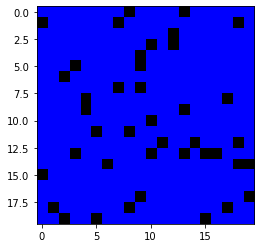

True


<Figure size 432x288 with 0 Axes>

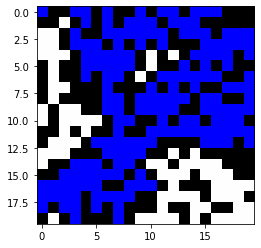

False


<Figure size 432x288 with 0 Axes>

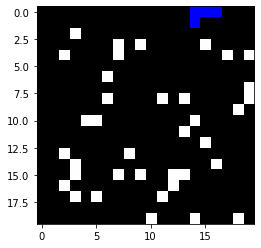

In [3]:
from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates an empty site, 1 indicates a blocked 
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = ["black", "white", "blue"]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.figure()
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)
    plt.show()


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)


model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

## Run replicate simulations across replicates with different bond occupation probabilities

The percolation probability represents an effective order parameter for this system, and
so we will attempt to calculate the percolation probability by performing many replicate
simulations at different values of $p$.

Running replicate simulations for p = 0.0
Running replicate simulations for p = 0.041666666666666664
Running replicate simulations for p = 0.08333333333333333
Running replicate simulations for p = 0.125
Running replicate simulations for p = 0.16666666666666666
Running replicate simulations for p = 0.20833333333333331
Running replicate simulations for p = 0.25
Running replicate simulations for p = 0.29166666666666663
Running replicate simulations for p = 0.3333333333333333
Running replicate simulations for p = 0.375
Running replicate simulations for p = 0.41666666666666663
Running replicate simulations for p = 0.4583333333333333
Running replicate simulations for p = 0.5
Running replicate simulations for p = 0.5416666666666666
Running replicate simulations for p = 0.5833333333333333
Running replicate simulations for p = 0.625
Running replicate simulations for p = 0.6666666666666666
Running replicate simulations for p = 0.7083333333333333
Running replicate simulations for p = 0.75
Running

Text(0, 0.5, 'Percolation probability')

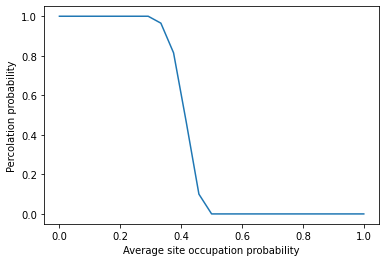

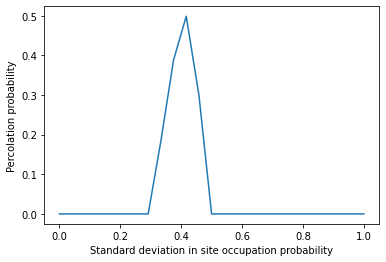

In [160]:
pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value

all_percolations = list()
for p in pvals:
    print("Running replicate simulations for p = {}".format(p), flush=True)
    all_replicates = list()
    for i in range(n_reps):
        # Initialize the model
        model = PercolationSimulation(30, p=p)
        all_replicates.append(model.percolate())
    all_percolations.append(all_replicates)

plt.figure()
plt.plot(pvals, np.mean(np.array(all_percolations), axis=1))
plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')

plt.figure()
plt.plot(pvals, np.std(np.array(all_percolations), axis=1))
plt.xlabel('Standard deviation in site occupation probability')
plt.ylabel('Percolation probability')


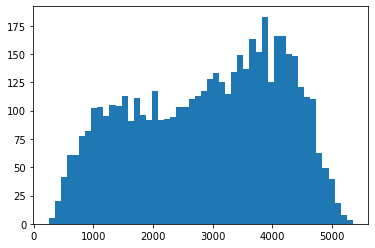

In [29]:
## Just from curiousity, plot the distribution of cluster sizes at the percolation threshold
## why does it appear to be bimodal?
all_cluster_sizes = list()
p_c = 0.407259
n_reps = 5000
for i in range(n_reps):
    model = PercolationSimulation(100, p=p_c)
    model.percolate()
    cluster_size = np.sum(model.grid_filled == 2)
    all_cluster_sizes.append(cluster_size)

    if i % 500 == 0:
        print("Finished simulation {}".format(i), flush=True)

all_cluster_sizes = np.array(all_cluster_sizes)

plt.hist(all_cluster_sizes, 50);